In [259]:
epsilon = 0.1
delta = 0.1
eta = 0.1

In [260]:
import numpy as np

class disjunction:
    def __init__(self, values):
        self.values = values
    
    def classify(self, x):        
        for (i, val) in enumerate(x):
            if val and self.values[i] == 1:
                return True
            elif not val and self.values[i] == -1:
                return True
        return False
        
    def get_dimension(self):
        return len(self.values)
    
    def get_terms(self):
        return self.values

In [261]:
class noisy_disjunction:
    def __init__(self, values, eta):
        self.values = values
        self.total_count = 0
        self.error_count = 0
        self.eta = eta
    
    def classify(self, x):
        returnVal = False
        self.total_count += 1
        for (i, val) in enumerate(x):
            if val and self.values[i] == 1:
                returnVal = True
                break
            elif not val and self.values[i] == -1:
                returnVal = True
                break
        
        rand = np.random.uniform(0, 1)   
        if self.total_count % 100 == 0:
            print(self.total_count)
        
        if rand < self.eta:
            self.error_count += 1
            return not returnVal
        
        return returnVal        
    
    def get_dimension(self):
        return len(self.values)
    
    def get_terms(self):
        return self.values    
    
    def get_counts(self):
        return self.total_count, self.error_count

In [262]:
def sprt(phi, a, r, curr_S):
    return curr_S + phi * np.log(a/r) + (1-phi) * np.log((1-a) / (1-r))

In [263]:
def make_good_disjunction(noisy_disjunction):
    values = noisy_disjunction.get_terms()
    
    return disjunction(values)

In [264]:
def get_sample_point(num_points):
    return np.array([bool(i) for i in np.random.randint(0, 2, num_points)])

In [265]:
def get_disjunction(num_points):
    prob = min(1/num_points, 1/3)
    #print(prob)
    values = np.random.choice([-1, 0, 1], num_points, replace=True, p=[prob, 1-2*prob, prob])
    
    if 1 not in values:
        index = np.random.randint(0, num_points)
        values[index] = 1
    
    if -1 not in values:
        index = np.random.randint(0, num_points)
        values[index] = -1
    
    return disjunction(values)
    

In [266]:
def get_noisy_disjunction(num_points, eta):
    prob = min(1/num_points, 1/3)
    #print(prob)
    values = np.random.choice([-1, 0, 1], num_points, replace=True, p=[prob, 1-2*prob, prob])
    if 1 not in values:
        index = np.random.randint(0, num_points)
        values[index] = 1
    
    if -1 not in values:
        index = np.random.randint(0, num_points)
        values[index] = -1
    return noisy_disjunction(values, eta)
    

In [267]:
def get_noisy_bound(epsilon, delta, eta, num_points):
    return (2 / epsilon ** 2) / (1 - 2*eta) ** 2 * (np.log(2 /delta) + num_points * np.log(3))

In [268]:
def find_noisy_consistent_disjunction(examples, max_errors, test_cap, classifications, num_points):
    found = False
    # print(eta)
    length = len(examples)
    checks = 0
    while not found and checks <= test_cap:
        C = get_disjunction(num_points)
        found = True
        errors = 0
        for i, example in enumerate(examples):
            if classifications[i] != C.classify(example):
                errors += 1
                if errors > max_errors:
                    # print(errors)
                    found = False
                    break
        checks += 1
    if found:
        return C, errors
    
    return None, -1

In [269]:
def S(true_concept, epsilon, delta, eta, K = 2):
    greater = np.random.uniform(0, 1) > 0.5
    dimension = true_concept.get_dimension()
    C = get_disjunction(dimension)
    hypotheses = np.array([C])
    deltas = np.array([6 * (delta) / np.pi ** 2])
    S_values = np.zeros(1)
    num_errors = np.zeros(1)
    min_errors = 0
    n = 1
    run = 0
    found = False
    concept = None
    examples = []
    classifications = []
    found_true = False
    found_false = False
    
    a = (epsilon - 2 * epsilon * eta) /K + eta
    r = epsilon + eta - 2 * epsilon * eta
    while not found:
        #print(len(examples))
        #print(n)
        run += 1
        example = get_sample_point(dimension)
        examples.append(example)
        curr_class = true_concept.classify(example)
        if curr_class:
            found_true = True
        else:
            found_false = True
        classifications.append(curr_class)
        for i in range(n):
            hyp = hypotheses[i]
            incorrect = 1
            if hyp.classify(example) == curr_class:
                incorrect = 0
                num_errors[i] += 1
            #print(sprt(incorrect, epsilon/K, epsilon, S_values[i]))
            S_values[i] = sprt(incorrect, a, r, S_values[i])
            #print(S_values[i])
        for i in range(n):
            if S_values[i] >= np.log(1/deltas[i]):
                found = True
                concept = hypotheses[i]
       # print(run)
        min_errors = np.min(num_errors)
        
        if hypotheses[-1].classify(example) != curr_class and (found_true and found_false):
            cap = 100
            if eta != 0:
                cap = 1/eta
            new_hyp, error_num = find_noisy_consistent_disjunction(examples, min_errors, cap, classifications, dimension)
            if error_num != -1:
                hypotheses = np.append(hypotheses, new_hyp)
                n += 1
                # print(n)
                deltas = np.append(deltas, 6 * (delta) / (np.pi ** 2 * n ** 2))
                S_values = np.append(S_values, 0)
                num_errors = np.append(num_errors, error_num)
        
    return concept, examples

In [270]:
C = get_noisy_disjunction(num_points, eta)
found, examples = S(C, epsilon, delta, eta)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [253]:
num_points = 50
C = get_noisy_disjunction(num_points, eta)
found, examples = S(C, epsilon, delta, eta)
true_class = 0
bad = 0
bad_examples = []
good_C = make_good_disjunction(C)
dimension = good_C.get_dimension()
total = 10000
for i in range(total):
    if (i % 1000 == 0):
        print(i)
    example = get_sample_point(dimension)
    if good_C.classify(example):
        true_class += 1
    if found.classify(example) != good_C.classify(example):
        bad += 1
        bad_examples.append(example)
        
print(bad/total > epsilon)
print(bad/total)

100
200
300
400
500
600
700
800
900
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
False
0.0


In [254]:
true_class

7548

In [255]:
good_C.get_terms()

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [256]:
# C = get_noisy_disjunction(num_points, eta)
C.get_terms()

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [257]:
found.get_terms()

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [271]:
get_noisy_bound(epsilon, delta, eta, num_points)

18101.98334592483

0
0
100
200
300
---------------------------
355
---------------------------
1
100
200
---------------------------
246
---------------------------
2
100
200
300
400
500
600
700
800
---------------------------
825
---------------------------
3
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
---------------------------
2472
---------------------------
4
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
---------------------------
1866
---------------------------


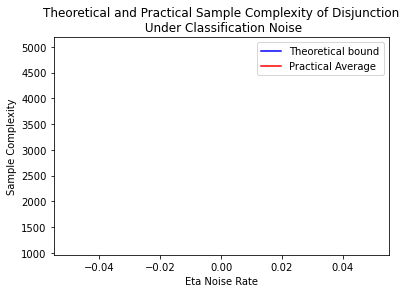

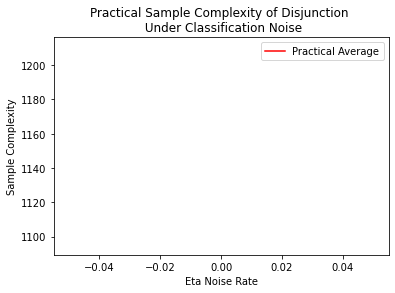

0.05
0
100
---------------------------
122
---------------------------
1
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
---------------------------
3256
---------------------------
2
100
200
300
400
500
600
700
800
900
1000
1100
---------------------------
1115
---------------------------
3
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
---------------------------
8665
---------------------------
4
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600

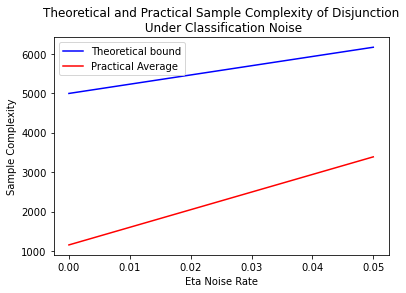

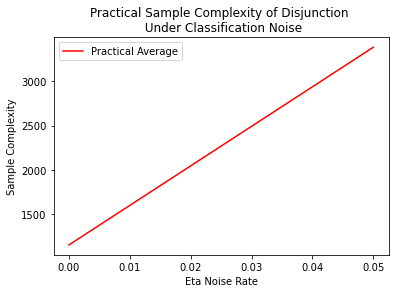

0.1
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
---------------------------
1617
---------------------------
1
100
200
300
---------------------------
390
---------------------------
2
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
---------------------------
8298
---------------------------
3
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
---------------------------
2798
---------------------------
4
100
200
300
400
---------------------------
430
---------------------------


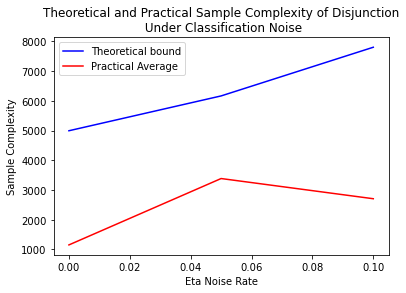

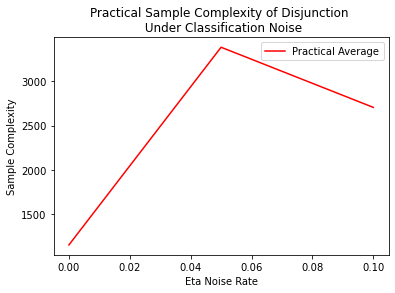

0.15
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
---------------------------
3304
---------------------------
1
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
---------------------------
4373
---------------------------
2
100
200
300
400
500
600
700
800
900
1000
1100
1200
---------------------------
1200
---------------------------
3
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000


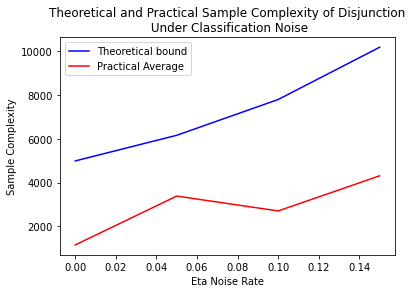

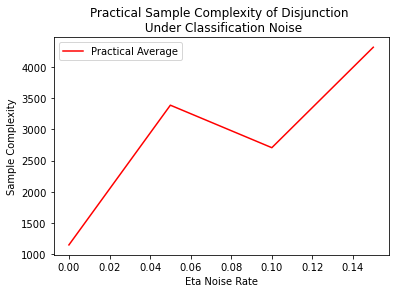

In [285]:
import csv
import matplotlib.pyplot as plt

trials = 5
dimension = 20
etas = [0, 0.05, 0.1, 0.15]

f = open('eta-versus-sample-DISJUNCT.csv', 'w')
writer = csv.writer(f)
writer.writerow(['eta', 'theoretical bound', 'practical sample'])

run = 0
bounds = []
records = []
means = []
for (i, curr_eta) in enumerate(etas):
    print(curr_eta)
    eta_record = []
    bounds.append(get_noisy_bound(epsilon, delta, curr_eta, dimension))
    for trial in range(trials):
        print(trial)
        C = get_noisy_disjunction(dimension, curr_eta)
        
        found, examples = S(C, epsilon, delta, curr_eta)
        eta_record.append(len(examples))
        print('---------------------------')
        print(len(examples))
        print('---------------------------')
    records.append(eta_record)
    means.append(np.mean(eta_record))
    row = [curr_eta, get_noisy_bound(epsilon, delta, curr_eta, dimension), np.mean(eta_record)]
    writer.writerow(row)
    writer.writerow(records)
    plt.plot(etas[:i+1], bounds, label="Theoretical bound", color='blue')
    plt.plot(etas[:i+1], means, label="Practical Average", color='red')
    plt.xlabel("Eta Noise Rate")
    plt.ylabel("Sample Complexity")
    plt.title("Theoretical and Practical Sample Complexity of Disjunction\n Under Classification Noise")
    plt.legend()
    run += 1
    plt.savefig("Disjunct-Whole-With-Large-Eta" + str(run) + '.png')
    plt.show()
    plt.plot(etas[:i+1], means, label="Practical Average", color='red')
    plt.xlabel("Eta Noise Rate")
    plt.ylabel("Sample Complexity")
    plt.title("Practical Sample Complexity of Disjunction \n Under Classification Noise")
    plt.legend()
    plt.savefig("Disjunct-Practical-With-Large-Eta" + str(run) + '.png')
    plt.show()
        

In [287]:

f = open('eta-versus-sample-DISJUNCT.csv', 'w')
writer = csv.writer(f)
writer.writerow(['eta', 'theoretical bound', 'practical sample'])

for (i, row) in enumerate(records):
    writer.writerow([etas[i], bounds[i], means[i]])
    writer.writerow(row)

0.2
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
---------------------------
6252
---------------------------
1
100
200
300
400
500
600
700
800
900
1000
---------------------------
1086
---------------------------
2
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
---------------------------
1655
---------------------------
3
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8

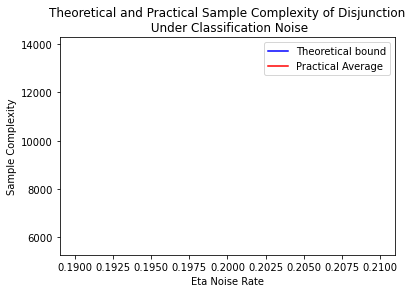

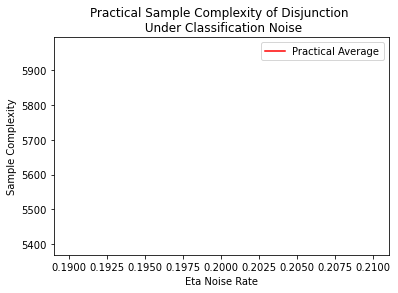

0.25
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
---------------------------
2607
---------------------------
1
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
---------------------------
1548
---------------------------
2
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
---------------------------
3474
---------------------------
3
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
---------------------------
2499
---------------------------
4
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
---------------------------
3513
---------------------------


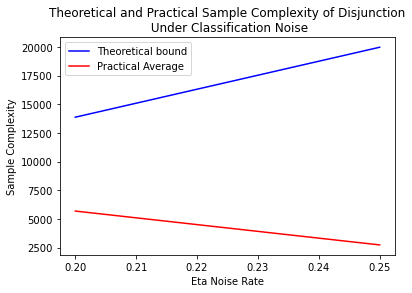

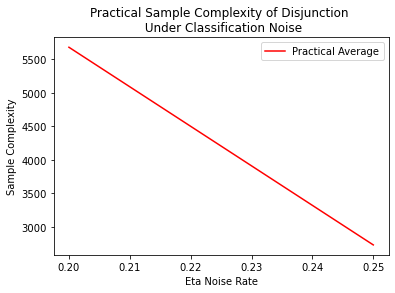

In [290]:
import csv
import matplotlib.pyplot as plt

trials = 5
dimension = 20
etas = [0.2, 0.25]

f = open('eta-versus-sample-DISJUNCT-2.csv', 'w')
writer = csv.writer(f)
writer.writerow(['eta', 'theoretical bound', 'practical sample'])

run = 0
bounds = []
records = []
means = []
for (i, curr_eta) in enumerate(etas):
    print(curr_eta)
    eta_record = []
    bounds.append(get_noisy_bound(epsilon, delta, curr_eta, dimension))
    for trial in range(trials):
        print(trial)
        C = get_noisy_disjunction(dimension, curr_eta)
        
        found, examples = S(C, epsilon, delta, curr_eta)
        eta_record.append(len(examples))
        print('---------------------------')
        print(len(examples))
        print('---------------------------')
    records.append(eta_record)
    means.append(np.mean(eta_record))
    row = [curr_eta, get_noisy_bound(epsilon, delta, curr_eta, dimension), np.mean(eta_record)]
    writer.writerow(row)
    writer.writerow(records)
    plt.plot(etas[:i+1], bounds, label="Theoretical bound", color='blue')
    plt.plot(etas[:i+1], means, label="Practical Average", color='red')
    plt.xlabel("Eta Noise Rate")
    plt.ylabel("Sample Complexity")
    plt.title("Theoretical and Practical Sample Complexity of Disjunction\n Under Classification Noise")
    plt.legend()
    run += 1
    #plt.savefig("Disjunct-Whole-With-Large-Eta" + str(run) + '.png')
    plt.show()
    plt.plot(etas[:i+1], means, label="Practical Average", color='red')
    plt.xlabel("Eta Noise Rate")
    plt.ylabel("Sample Complexity")
    plt.title("Practical Sample Complexity of Disjunction \n Under Classification Noise")
    plt.legend()
    #plt.savefig("Disjunct-Practical-With-Large-Eta" + str(run) + '.png')
    plt.show()
        

In [291]:
print(bounds)
print(means)

[13871.098914953436, 19974.382437532946]
[5682.0, 2728.2]
